<a href="https://colab.research.google.com/github/Arj05/Automatic-Number-Plate-Recognition/blob/main/CQ_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload the weights-dist.tar file


Saving weights-dist.tar to weights-dist (4).tar
Dataset Loaded Successfully!
Total Routes: 294
Unique Origins: 79
Unique Destinations: 79

Training Reinforcement Learning Model...
Episode: 1/1000, Total Reward: -4
Episode: 2/1000, Total Reward: -4
Episode: 3/1000, Total Reward: -4
Episode: 4/1000, Total Reward: -4
Episode: 5/1000, Total Reward: -4
Episode: 6/1000, Total Reward: -4
Episode: 7/1000, Total Reward: -4
Episode: 8/1000, Total Reward: -4
Episode: 9/1000, Total Reward: -4
Episode: 10/1000, Total Reward: -4
Episode: 11/1000, Total Reward: -4
Episode: 12/1000, Total Reward: -4
Episode: 13/1000, Total Reward: -4
Episode: 14/1000, Total Reward: -4
Episode: 15/1000, Total Reward: -4
Episode: 16/1000, Total Reward: -4
Episode: 17/1000, Total Reward: -4
Episode: 18/1000, Total Reward: -4
Episode: 19/1000, Total Reward: -4
Episode: 20/1000, Total Reward: -4
Episode: 21/1000, Total Reward: -4
Episode: 22/1000, Total Reward: 8.0
Episode: 23/1000, Total Reward: -4
Episode: 24/1000, Total

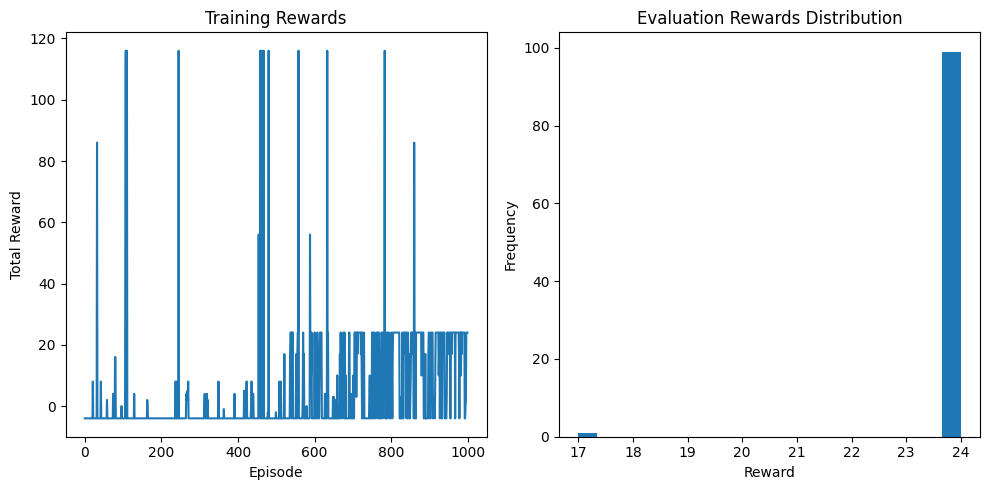

In [5]:
import os
import tarfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from google.colab import files
import io

class RoutingEnvironment:
    def __init__(self, dataset):
        self.dataset = dataset

        # Preprocess data
        self.locations = list(set(
            dataset['Origin'].tolist() +
            dataset['Destination'].tolist()
        ))
        self.location_to_index = {loc: idx for idx, loc in enumerate(self.locations)}

        # Environment parameters
        self.max_route_length = 5
        self.current_route = []

    def reset(self):
        # Reset the environment
        self.current_route = []
        initial_location = random.choice(self.locations)
        return self._get_state(initial_location)

    def _get_state(self, current_location):
        # Create a state representation
        route_length = len(self.current_route)
        current_location_index = self.location_to_index[current_location]

        return np.array([
            current_location_index,
            route_length,
            len(self.locations)
        ], dtype=np.float32)

    def step(self, action):
        # Convert action to location
        next_location = self.locations[action]

        # Add location to route
        self.current_route.append(next_location)

        # Calculate reward
        reward = self._calculate_reward()

        # Check if episode is done
        done = (len(self.current_route) >= self.max_route_length)

        # Get next state
        next_state = self._get_state(next_location)

        return next_state, reward, done

    def _calculate_reward(self):
        # Complex reward function
        if len(self.current_route) < 2:
            return 0

        # Check if the route exists in the dataset
        for i in range(len(self.current_route) - 1):
            origin = self.current_route[i]
            destination = self.current_route[i+1]

            route_exists = self.dataset[
                (self.dataset['Origin'] == origin) &
                (self.dataset['Destination'] == destination)
            ]

            if not route_exists.empty:
                # Reward for valid routing
                return route_exists['Weight'].values[0]

        # Penalty for invalid routing
        return -1

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Neural Network for Q-learning
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state)
            return torch.argmax(act_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        # Sample batch from memory
        minibatch = random.sample(self.memory, batch_size)

        # Prepare tensors
        states = torch.FloatTensor(np.array([s[0] for s in minibatch]))
        actions = torch.LongTensor(np.array([s[1] for s in minibatch]))
        rewards = torch.FloatTensor(np.array([s[2] for s in minibatch]))
        next_states = torch.FloatTensor(np.array([s[3] for s in minibatch]))
        dones = torch.FloatTensor(np.array([s[4] for s in minibatch]))

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1)[0]
            targets = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute current Q values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute loss
        loss = self.loss_fn(current_q_values, targets)

        # Gradient descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def extract_dataset_from_upload(uploaded_bytes):
    """Extract uploaded tar file and load dataset"""
    try:
        # Create a bytes buffer
        tar_bytes = io.BytesIO(uploaded_bytes)

        # Extract tar file
        with tarfile.open(fileobj=tar_bytes, mode='r') as tar:
            # Extract to a temporary directory
            extract_path = '/content/weights-dist'
            tar.extractall(path=extract_path)

        # Find the .intra file
        for root, dirs, files in os.walk(extract_path):
            for file in files:
                if file.endswith('.intra'):
                    dataset_path = os.path.join(root, file)

                    # Load dataset with flexible parsing
                    try:
                        with open(dataset_path, 'r') as f:
                            lines = f.readlines()

                        # Parse lines manually
                        data = []
                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) >= 3:
                                origin = parts[0].replace('+', ' ')
                                destination = parts[1].replace('+', ' ')
                                weight = float(parts[-1])
                                data.append([origin, destination, weight])

                        # Create DataFrame
                        df = pd.DataFrame(data, columns=['Origin', 'Destination', 'Weight'])

                        return df

                    except Exception as e:
                        print(f"Error loading dataset: {e}")
                        return None

        print("No .intra file found in the uploaded tar")
        return None

    except Exception as e:
        print(f"Error processing uploaded file: {e}")
        return None

def train_routing_model(dataset, episodes=1000, batch_size=32):
    # Create environment
    env = RoutingEnvironment(dataset)

    # Initialize agent
    agent = DQNAgent(
        state_size=3,  # Fixed state size
        action_size=len(env.locations)
    )

    # Training loop
    training_rewards = []
    for e in range(episodes):
        # Reset environment
        state = env.reset()

        # Initialize tracking variables
        total_reward = 0
        done = False

        while not done:
            # Choose action
            action = agent.act(state)

            # Take action
            next_state, reward, done = env.step(action)

            # Remember the experience
            agent.remember(state, action, reward, next_state, done)

            # Update state and reward
            state = next_state
            total_reward += reward

            # Experience replay
            agent.replay(batch_size)

        # Store episode rewards
        training_rewards.append(total_reward)

        # Print progress
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}")

    return agent, env, training_rewards

def evaluate_model(agent, env, num_episodes=100):
    total_rewards = []

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)

            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)

    # Calculate confidence metrics
    avg_reward = np.mean(total_rewards)
    reward_std = np.std(total_rewards)
    confidence_interval = (
        avg_reward - 1.96 * (reward_std / np.sqrt(num_episodes)),
        avg_reward + 1.96 * (reward_std / np.sqrt(num_episodes))
    )

    print("\nModel Evaluation:")
    print(f"Average Reward: {avg_reward}")
    print(f"Reward Standard Deviation: {reward_std}")
    print(f"95% Confidence Interval: {confidence_interval}")

    return total_rewards

def main():
    # Upload dataset
    print("Please upload the weights-dist.tar file")
    uploaded = files.upload()

    # Extract and load dataset
    dataset = None
    for filename, file_content in uploaded.items():
        if filename.endswith('.tar'):
            dataset = extract_dataset_from_upload(file_content)
            break

    if dataset is not None:
        # Print dataset information
        print("Dataset Loaded Successfully!")
        print(f"Total Routes: {len(dataset)}")
        print(f"Unique Origins: {dataset['Origin'].nunique()}")
        print(f"Unique Destinations: {dataset['Destination'].nunique()}")

        # Train the model
        print("\nTraining Reinforcement Learning Model...")
        trained_agent, environment, training_rewards = train_routing_model(dataset)

        # Evaluate the model
        print("\nEvaluating Model Performance...")
        evaluation_rewards = evaluate_model(trained_agent, environment)

        # Visualize training progress
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(training_rewards)
        plt.title('Training Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')

        plt.subplot(1, 2, 2)
        plt.hist(evaluation_rewards, bins=20)
        plt.title('Evaluation Rewards Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()
    else:
        print("Failed to load dataset")

# Run the main function
main()